In [33]:
from collections import Counter
import json 
import os
import os.path as path
from pprint import pprint
import re
from datetime import datetime, timedelta
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

In [35]:
# directories
root_dir = path.dirname(os.getcwd())
logs_dir = path.join(root_dir, f"logs/reddit")
original_dir = path.join(root_dir, f"data/reddit/original")
preprocessed_dir = path.join(root_dir, f"data/reddit/preprocessed")

# constants
START = datetime(2020, 1, 1)
END = datetime(2022, 1, 1)
N_DATES = (END - START).days
ALL_DATES = set([START + timedelta(i) for i in range(N_DATES)])

## Scraping overview

In [10]:
# load scraping logs for posts and comments
modes = ['posts', 'comments']
logs = {mode: [] for mode in modes}

for mode in modes:
    mode_dir = path.join(logs_dir, mode)
    filepaths = [
        path.join(mode_dir, filename) 
        for filename in sorted(os.listdir(mode_dir))]

    # load logs as dataframe
    df = []
    for filepath in filepaths:
        with open(filepath, 'r') as f:
            x = json.load(f)
            assert x['mode'] == mode
            
            df.append(x)
    logs[mode] = pd.DataFrame(df)
    display(logs[mode].head()) # peek

,mode,date_scraped,run_date,shard_data,time_taken
0,posts,2020-01-01,2022-01-30 15:14,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",11.9s
1,posts,2020-01-02,2022-01-30 15:14,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",12.5s
2,posts,2020-01-03,2022-01-30 15:14,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",11.7s
3,posts,2020-01-04,2022-01-30 15:15,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",16.2s
4,posts,2020-01-05,2022-01-30 15:15,"{'failed': 0, 'skipped': 0, 'successful': 20, ...",22.8s


,mode,date_scraped,run_date,shard_data,time_taken
0,comments,2020-01-01,2022-01-30 13:22,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",14.7s
1,comments,2020-01-02,2022-01-30 13:22,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",16.7s
2,comments,2020-01-03,2022-01-30 13:23,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",16.3s
3,comments,2020-01-04,2022-01-30 13:23,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",16.5s
4,comments,2020-01-05,2022-01-30 13:23,"{'failed': 0, 'skipped': 0, 'successful': 67, ...",13.5s


Total number of days: 731
Missing days: []
Number of days with posts fully scraped: 419
Number of days with no scraping metadata: 0


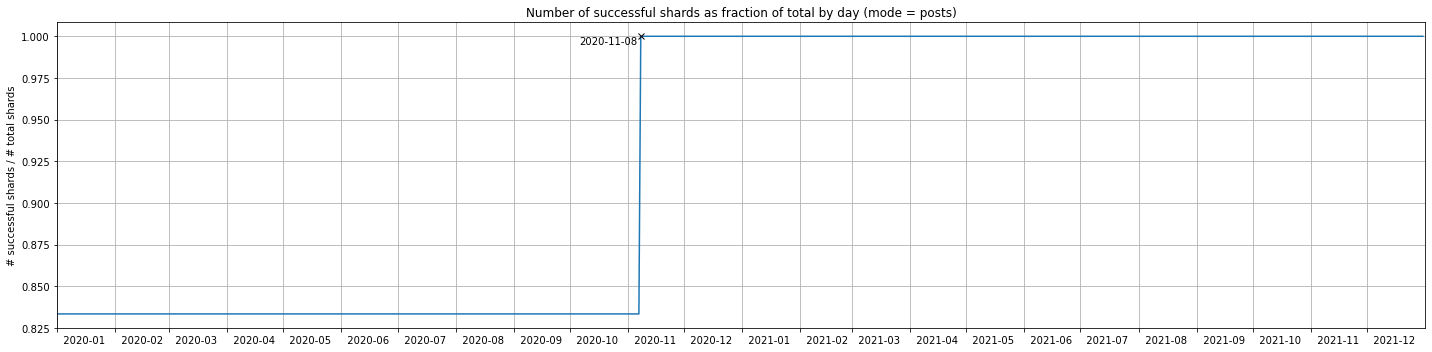

Total number of days: 713
Missing days: ['2021-01-10', '2021-01-25', '2021-01-26', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-11', '2021-09-05', '2021-09-06', '2021-09-21', '2021-09-25', '2021-09-26', '2021-09-28', '2021-12-15', '2021-12-16', '2021-12-20', '2021-12-25', '2021-12-26']
Number of days with comments fully scraped: 401
Number of days with no scraping metadata: 0


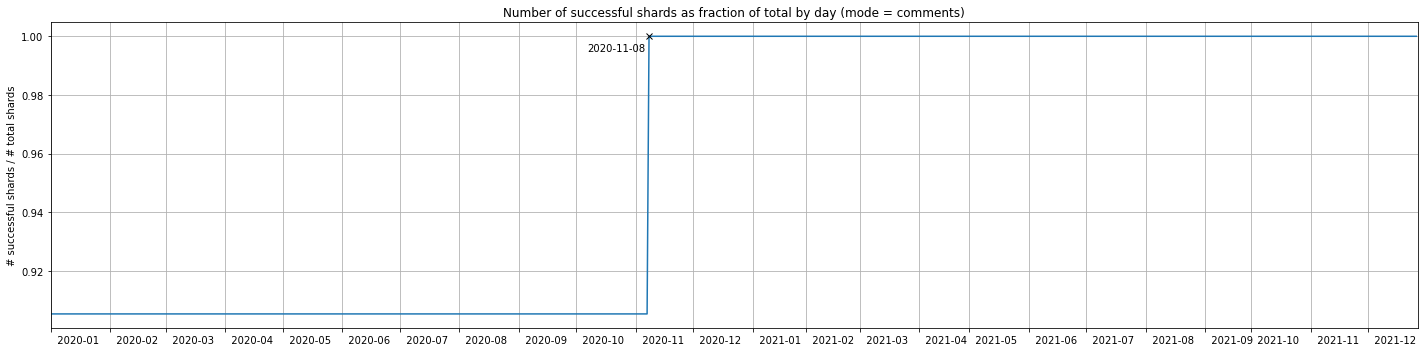

In [38]:
# compute and plot scraping statistics based on shard_data
# if n_successful/n_total != 1, then some data may be missing

for mode in modes:
    df = logs[mode]

    n_successful = np.array(df.shard_data.apply(
        lambda x: x['successful'] if x is not None else 0))
    n_total = np.array(df.shard_data.apply(
        lambda x: x['total'] if x is not None else 1))
        
    # report any missing dates
    prettydates = df.date_scraped.tolist()
    dates = [datetime(*[int(_) for _ in x.split('-')]) for x in prettydates]
    missing_dates = [x.strftime('%Y-%m-%d') for x in ALL_DATES - set(dates)]

    print(f"Total number of days: {len(prettydates)}")
    print(f"Missing days: {sorted(missing_dates)}")
    print(f"Number of days with {mode} fully scraped: {sum(n_successful == n_total)}")
    print(f"Number of days with no scraping metadata: {df.shard_data.apply(lambda x: x is None).sum()}")

    if True:
        plt.figure(figsize=(20, 5))
        plt.plot(n_successful / n_total)
        
        idx = np.where(n_successful == n_total)[0][0]
        plt.plot(idx, 1, marker='x', color='black')
        plt.text(idx-2, 0.995, s=prettydates[idx], ha='right')

        plt.title(f"Number of successful shards as fraction of total by day (mode = {mode})")
        plt.ylabel("# successful shards / # total shards")
        plt.xlim(0, len(prettydates))
        plt.xticks(
            ticks=[i for i, x in enumerate(prettydates) if x.endswith("01")], 
            labels=["  " + x[:-3] for x in prettydates if x.endswith("01")], 
            ha="left")

        plt.grid()
        plt.tight_layout()
        plt.show()

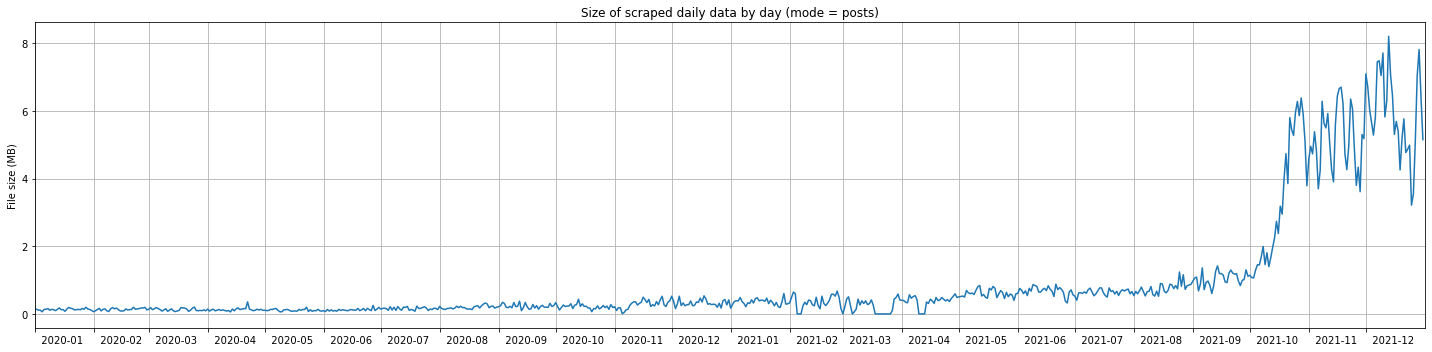

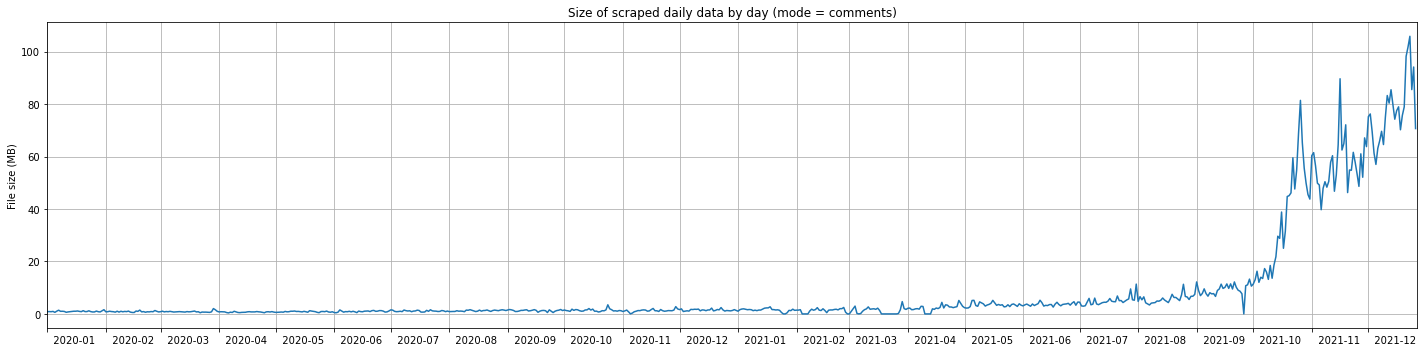

In [12]:
# how large are the scraped files for each day?
# a few filesizes are 0MB; this is due to reddit/pushshift outages on those days

for mode in modes:
    mode_dir = path.join(original_dir, mode)
    filenames = sorted(os.listdir(mode_dir))
    filepaths = [path.join(mode_dir, filename) for filename in filenames]

    dates = [filename[:10] for filename in filenames]
    filesizes = np.array(
        [path.getsize(filepath) for filepath in filepaths]) / (1024**2)

    if True:
        plt.figure(figsize=(20, 5))
        plt.plot(filesizes)

        plt.title(f"Size of scraped daily data by day (mode = {mode})")
        plt.ylabel("File size (MB)")
        plt.xlim(0, len(dates))
        plt.xticks(
            ticks=[i for i, date in enumerate(dates) if date.endswith("01")], 
            labels=["  " + date[:-3] for date in dates if date.endswith("01")], 
            ha="left")
        plt.grid()
        plt.tight_layout()
        plt.show()

### Exploration of all scraped posts

In [40]:
# prepwork
mode = 'posts'
posts_dir = path.join(original_dir, mode)

# load scraped posts
posts = []
for filename in tqdm(sorted(os.listdir(posts_dir))):
    filepath = path.join(posts_dir, filename)
    with open(filepath, 'r') as f:
        for line in f:
            x = json.loads(line)
            posts.append(x)
posts = pd.DataFrame(posts)
posts.fillna(False, inplace=True)

100%|██████████| 731/731 [00:19<00:00, 37.12it/s] 


In [9]:
# basic statistics
print(f"Number of posts scraped: {posts.shape[0]}")
print(f"Number of posts removed/deleted: {posts.removed_by_category.apply(lambda x: 1 if x else 0).sum()}")
print(f"Number of posts with no selftext: {posts.selftext.apply(lambda x: 0 if x else 1).sum()}")

idx = (posts.removed_by_category == False) & (posts.selftext.apply(bool))
posts = posts[idx].reset_index()
print(f"Number of posts remaining: {posts.shape[0]}")

Number of posts scraped: 162536
Number of posts removed/deleted: 8266
Number of posts with no selftext: 84668
Number of posts remaining: 72894


In [10]:
# author statistics
print(f"Number of unique authors: {posts.author.nunique()}")
print(f"Number of authors with 1 post: {len([author for author, freq in posts.author.value_counts().items() if freq == 1])}")
print(f"Number of authors with >50 posts: {len([author for author, freq in posts.author.value_counts().items() if freq > 50])}")
print(f"Most prolific authors: {list(posts.author.value_counts()[:5].items())}")

Number of unique authors: 49170
Number of authors with 1 post: 39050
Number of authors with >50 posts: 12
Most prolific authors: [('_Raspootin_', 145), ('Advi0001', 98), ('nbatman', 95), ('isle_of_cats', 88), ('AutoModerator', 85)]


### Exploration of preprocessed filtered posts

In [47]:
# prepwork
mode = 'posts'
posts_dir = path.join(preprocessed_dir, mode)

# load filtered posts
posts = []
for filename in tqdm(sorted(os.listdir(posts_dir))):
    filepath = path.join(posts_dir, filename)
    with open(filepath, 'r') as f:
        for line in f:
            x = json.loads(line)
            posts.append(x)
posts = pd.DataFrame(posts)
posts.fillna(False, inplace=True)

100%|██████████| 7/7 [00:00<00:00, 255.26it/s]


In [52]:
# peek 
x = posts.loc[0]
print(f"Author: {x['author']}\n")
print(f"Original selftext:\n{x['selftext']}\n")
print(f"Lemmatized selftext:")
for s in x['lemmatized_selftext']:
    print(f"- {' '.join(s)}")
print(f"\nFiltered lemmatized selftext:")
for s in x['filtered_lemmatized_selftext']:
    print(f"- {' '.join(s)}")

Author: loosesealbluth11

Original selftext:
I just discovered this sub and am thrilled you people exist. 

Last year, I quit my mid-six-figure paying job, left my city, my apartment, my life, and moved up into the mountains several hours away from it all. I did this because I was not only fed up with what work had become (pointless, useless, empty) but because I was in a powerful position implementing rules and structures that were only there to get people to work more so I could pay them less. 

I managed a team of 65 people, and I worked together with my business partner to ensure they stayed at the company while paying them as little as we could but offering them as many bullshit tech industry freebies as we could to keep them engaged (turns out, millennials love snacks, beer, and gym memberships). 

I was part of the problem and simply quit one day because I didn't want to participate anymore. I couldn't participate anymore. I didn't have a name for what I felt, it just felt wrong